# Deep Learning Course - Ex2
Submitted by : Idan Cohen ****** and Moshe Beutel 037580792

### imports

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

Define epsilon that will be used for numerical stability

In [2]:
epsilon = 1e-9  

## Part 1 - Read and visualize the data

In [25]:
train_val_ratio = 0.1
# read the data
def data_read(train_val_ratio):
    train_data = pd.read_csv('train.csv').to_numpy()
    test_data = pd.read_csv('test.csv').to_numpy()

    N = train_data.shape[0]
    indices = np.random.permutation(N)
    indices_train, indices_val = indices[:int(N * train_val_ratio)], indices[int(N * train_val_ratio):]

    x_train = train_data[indices_train, 1:]
    y_train = train_data[indices_train, 0]
    x_val = train_data[indices_val, 1:]
    y_val = train_data[indices_val, 0]
    x_test = test_data
    return x_train, y_train, x_val, y_val, x_test
	
x_train, y_train, x_val, y_val, x_test = data_read(train_val_ratio)


Preform preprocessing on the data:
1. Scaling - scale the pixel value for better numerical stability. Use min-max scaler
2. Convert labels to one-hot vector to enable vectorized calculations


In [26]:
def one_hot_encode(y):
    y_one_hot = np.zeros((y.size,10))
    y_one_hot[np.arange(y.size),y] = 1
    return y_one_hot
class MinMaxScaler():
    """
    A Min-Max Scaler that is to be fit to the train data.
    """
    def __init__(self, x_train):
        self.x_min = np.min(x_train, axis=0)
        self.x_max = np.max(x_train, axis=0)

    def scale(self, x):
        """
        A method used to scale new data based on the MinMaxScaler that was defined by the train data.
        :param x: Data matrix to be scaled
        :return: Scaled data
        """
        x_scaled = (x - self.x_min) / (self.x_max - self.x_min + epsilon)
        return x_scaled

def preprocess(x_train, y_train, x_val, y_val, x_test):
    y_train_one_hot = one_hot_encode(y_train).T
    y_val_one_hot = one_hot_encode(y_val).T

    scaler = MinMaxScaler(x_train)
    x_train = scaler.scale(x_train).T
    x_val = scaler.scale(x_val).T
    x_test = scaler.scale(x_test).T
    return x_train, y_train_one_hot, x_val, y_val_one_hot, x_test

x_train, y_train, x_val, y_val, x_test = preprocess(x_train, y_train, x_val, y_val, x_test)
	

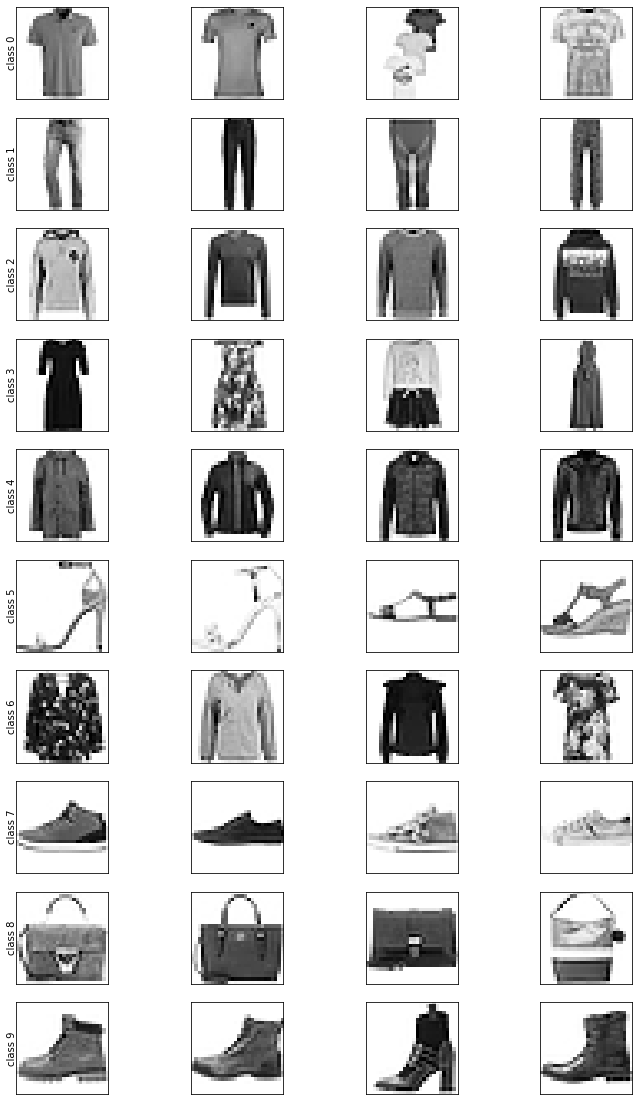

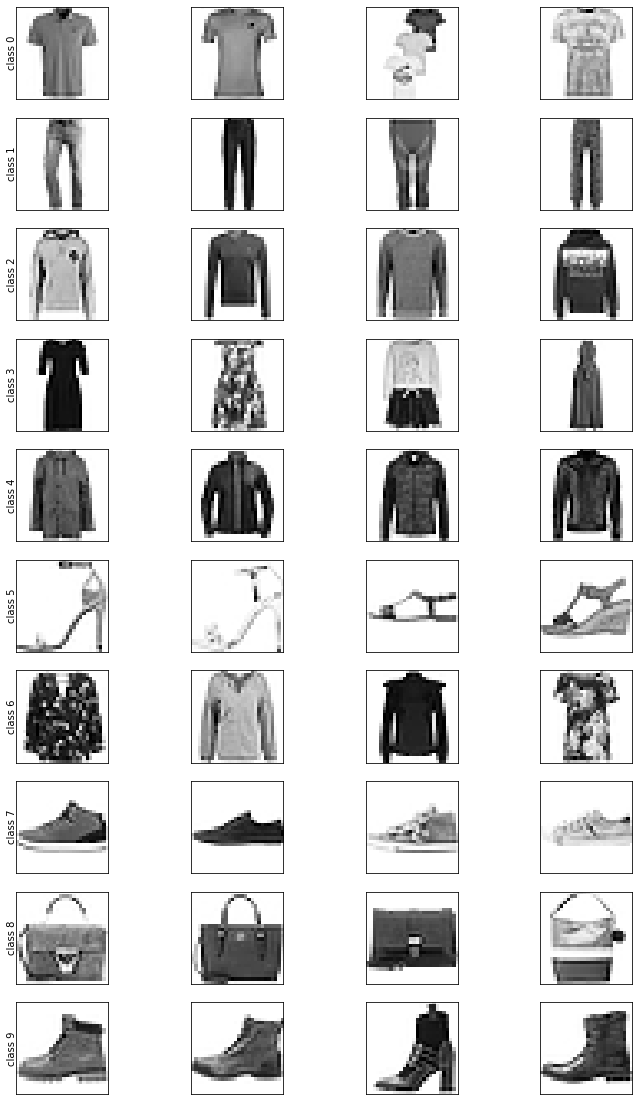

In [39]:
def visualize_data(x_train, y_train):
    fig, axes = plt.subplots(10, 4, figsize=(12, 20))
    labels = np.argmax(y_train, axis=0)
    for label in range(10):
        indices_of_label = np.where(labels == label)[0]
        for i in range(4):
            if i == 0:
                axes[label, i].set_ylabel('class '+str(label),verticalalignment='center')

            axes[label, i].imshow(x_train[:, indices_of_label[i]].reshape(28, 28), cmap='Greys')
            axes[label, i].set_xticks([])
            axes[label, i].set_yticks([])
    return fig

visualize_data(x_train, y_train)

## Part 2 - Logistic Regression

Logistic regression needs the following building blocks:
1. **Softmax** function - In order to use the Logistic regression as a classifier the logits need to be converted to probabilities over the possible classes - $p(c_{i}|X;W, b)$
2. **Cross-Entropy** loss function - The function that our model will minimize
3. **L2-Regularization** - Encourage smaller weights in order to overcome overfitting
4. **dL_dw** - The gradient of the loss with respect to the parameters

**Note:** Those buiding blocks shall be used in the neural-network as well. 

In [97]:
def softmax(a):
    d = a - np.matmul(np.ones((a.shape[0], 1)) , (np.max(a, axis=0).reshape(1, a.shape[1])))
    return np.exp(d) / np.sum(np.exp(d), axis=0).reshape(1, d.shape[1])

# machine learning functions

def cross_entropy_loss(softmax_z, y_true_one_hot):
    loss = np.sum(np.log(softmax_z + epsilon) * y_true_one_hot)
    return - loss / softmax_z.shape[1]

def l2_reg(w, l2_lambda):
    reg_term = l2_lambda * np.sum(np.power(w,2))
    return reg_term

def dL2_dw(w, l2_lambda):
    reg_derivative = 2 * l2_lambda * w
    return reg_derivative

def l1_reg(w, l1_lambda):
    reg_term = l1_lambda * np.sum(np.abs(w))
    return reg_term

def dL1_dw(w, l1_lambda):
    reg_derivative = np.sign(w) * l1_lambda
    return reg_derivative

def dL_dw(softmax_z, y_true, x):
    dL = np.matmul((y_true - softmax_z), x.T)
    return - dL / softmax_z.shape[1]


### Define the logistic regression process and test

In [98]:
def logistic_regression(x_train, y_train, x_val, y_val, x_test, batch_size, lr, epochs, l2_lambda, l1_lambda=0.0):
    # add a feature for the bias

    x_train_full = np.vstack([x_train, np.ones([1, x_train.shape[1]])])
    x_val_full = np.vstack([x_val, np.ones([1, x_val.shape[1]])])
    x_test_full = np.vstack([x_test, np.ones([1, x_test.shape[1]])])

    N = x_train_full.shape[1]
    w_dim = x_train_full.shape[0]

    w = np.random.normal(loc=0.0, scale=0.01,
                         size=(10, w_dim))  # initialize weights iid from a gaussian with small noise
    train_losses, train_accuracy, val_losses, val_accuracy = [], [], [], []

    # iterations over entire dataset
    for epoch in tqdm(range(epochs)):
        loss = 0
        # batch iterations within each dataset iteration
        for batch_idx, idx_start in enumerate(range(0, N, batch_size)):
            idx_end = min(idx_start + batch_size, N)
            x_batch = x_train_full[:, idx_start:idx_end]  # take all data in the current batch
            y_batch = y_train[:, idx_start:idx_end]  # .reshape(-1, 1)  # take relevant labels
            # matrix-vector multiplication
            z = np.matmul(w, x_batch)
            # calc. probability of y_j = 1 for each input (batch_size,)
            softmax_z = softmax(z)

            # calculate loss

            batch_loss = cross_entropy_loss(softmax_z, y_batch) + l2_reg(w,l2_lambda) + l1_reg(w,l1_lambda)
            loss += batch_loss
            # compute gradient of the loss w.r.t w

            delta_w = dL_dw(softmax_z, y_batch, x_batch) + 2 * l2_lambda * w + dL1_dw(w, l1_lambda)
            # update w
            w = w - lr * delta_w

        # validation
        val_acc, val_loss = test(x_val_full, w, l2_lambda, y_true=y_val)
        train_acc, _ = test(x_train_full, w, l2_lambda, y_true=y_train)
        # save for plotting
        train_losses.append(loss / (len(range(0, N, batch_size)) - 1))
        train_accuracy.append(train_acc)

        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        print('Epoch:' + str(epoch) + '    Train Acc: ' + str(train_acc) + '    Val Acc: ' + str(val_acc))

    # save the test results to a file
    test_preds = test(x_test_full, w, l2_lambda, y_true=None).astype(int)
    file_name = 'lr_pred.csv'
    print(test_preds)
    np.savetxt(file_name, test_preds, fmt='%i')

    return train_losses, train_accuracy, val_losses, val_accuracy

def test(x, w, l2_lambda, y_true=None):
    z = np.matmul(w, x)
    softmax_z = softmax(z)
    predictions = np.argmax(softmax_z, axis=0)
    if y_true is None:
        return predictions

    else:
        test_loss = cross_entropy_loss(softmax_z, y_true) + l2_reg(w, l2_lambda)
        accuracy = np.mean(np.equal(np.argmax(y_true, axis=0), predictions))
        return accuracy, test_loss


### Define Hyper-Parameters

In [103]:
num_epochs = 500
batch_size = 1024
lr = 1
lr = 0.1
l2_lambda = 0
l1_lambda =0.5
NN_width = 500


In [104]:
train_loss_list, train_accuracy, val_loss_list, val_accuracy =\
    logistic_regression(x_train, y_train, x_val, y_val, x_test, batch_size, lr, num_epochs, l2_lambda)

  1%|          | 3/500 [00:00<00:23, 21.49it/s]

Epoch:0    Train Acc: 0.6551785714285714    Val Acc: 0.655218253968254
Epoch:1    Train Acc: 0.6617857142857143    Val Acc: 0.6613690476190476
Epoch:2    Train Acc: 0.6719642857142857    Val Acc: 0.6693849206349206
Epoch:3    Train Acc: 0.6882142857142857    Val Acc: 0.6812698412698412
Epoch:4    Train Acc: 0.7048214285714286    Val Acc: 0.6951388888888889


  2%|▏         | 9/500 [00:00<00:22, 21.43it/s]

Epoch:5    Train Acc: 0.7205357142857143    Val Acc: 0.7085912698412699
Epoch:6    Train Acc: 0.7323214285714286    Val Acc: 0.7194444444444444
Epoch:7    Train Acc: 0.7423214285714286    Val Acc: 0.7283928571428572
Epoch:8    Train Acc: 0.7491071428571429    Val Acc: 0.7373611111111111
Epoch:9    Train Acc: 0.755    Val Acc: 0.7441269841269841


  3%|▎         | 15/500 [00:00<00:23, 20.64it/s]

Epoch:10    Train Acc: 0.7591071428571429    Val Acc: 0.7499007936507937
Epoch:11    Train Acc: 0.7655357142857143    Val Acc: 0.7539880952380953
Epoch:12    Train Acc: 0.7708928571428572    Val Acc: 0.7586706349206349
Epoch:13    Train Acc: 0.7739285714285714    Val Acc: 0.7629960317460317
Epoch:14    Train Acc: 0.7775    Val Acc: 0.7665873015873016


  4%|▎         | 18/500 [00:00<00:23, 20.71it/s]

Epoch:15    Train Acc: 0.7805357142857143    Val Acc: 0.7701984126984127
Epoch:16    Train Acc: 0.7844642857142857    Val Acc: 0.7734920634920635
Epoch:17    Train Acc: 0.7875    Val Acc: 0.7761111111111111
Epoch:18    Train Acc: 0.7898214285714286    Val Acc: 0.7790277777777778
Epoch:19    Train Acc: 0.7926785714285715    Val Acc: 0.7813095238095238


  5%|▍         | 24/500 [00:01<00:23, 20.50it/s]

Epoch:20    Train Acc: 0.7941071428571429    Val Acc: 0.7831150793650794
Epoch:21    Train Acc: 0.7964285714285714    Val Acc: 0.785079365079365
Epoch:22    Train Acc: 0.7982142857142858    Val Acc: 0.7864087301587301
Epoch:23    Train Acc: 0.7991071428571429    Val Acc: 0.7879365079365079
Epoch:24    Train Acc: 0.80125    Val Acc: 0.7892261904761905


  6%|▌         | 30/500 [00:01<00:22, 20.88it/s]

Epoch:25    Train Acc: 0.8030357142857143    Val Acc: 0.7908730158730158
Epoch:26    Train Acc: 0.8044642857142857    Val Acc: 0.7922420634920635
Epoch:27    Train Acc: 0.8058928571428572    Val Acc: 0.7933333333333333
Epoch:28    Train Acc: 0.8066071428571429    Val Acc: 0.7941269841269841
Epoch:29    Train Acc: 0.8066071428571429    Val Acc: 0.7953769841269841


  7%|▋         | 33/500 [00:01<00:22, 20.95it/s]

Epoch:30    Train Acc: 0.8073214285714285    Val Acc: 0.7968650793650793
Epoch:31    Train Acc: 0.8082142857142857    Val Acc: 0.7981349206349206
Epoch:32    Train Acc: 0.80875    Val Acc: 0.7992261904761905
Epoch:33    Train Acc: 0.8110714285714286    Val Acc: 0.8000198412698413
Epoch:34    Train Acc: 0.8126785714285715    Val Acc: 0.8008531746031746


  8%|▊         | 39/500 [00:01<00:21, 21.16it/s]

Epoch:35    Train Acc: 0.8132142857142857    Val Acc: 0.8014682539682539
Epoch:36    Train Acc: 0.8133928571428571    Val Acc: 0.801984126984127
Epoch:37    Train Acc: 0.8160714285714286    Val Acc: 0.8026785714285715
Epoch:38    Train Acc: 0.8167857142857143    Val Acc: 0.8033333333333333
Epoch:39    Train Acc: 0.8178571428571428    Val Acc: 0.8040873015873016


  9%|▉         | 45/500 [00:02<00:21, 21.01it/s]

Epoch:40    Train Acc: 0.8189285714285715    Val Acc: 0.8047420634920635
Epoch:41    Train Acc: 0.82    Val Acc: 0.8054166666666667
Epoch:42    Train Acc: 0.8208928571428571    Val Acc: 0.8058730158730159
Epoch:43    Train Acc: 0.8221428571428572    Val Acc: 0.8064087301587302
Epoch:44    Train Acc: 0.8230357142857143    Val Acc: 0.807063492063492


 10%|▉         | 48/500 [00:02<00:21, 21.08it/s]

Epoch:45    Train Acc: 0.82375    Val Acc: 0.8077182539682539
Epoch:46    Train Acc: 0.8251785714285714    Val Acc: 0.8081746031746032
Epoch:47    Train Acc: 0.8264285714285714    Val Acc: 0.8087103174603174
Epoch:48    Train Acc: 0.8273214285714285    Val Acc: 0.8090674603174604
Epoch:49    Train Acc: 0.8285714285714286    Val Acc: 0.8095436507936508


 11%|█         | 54/500 [00:02<00:20, 21.26it/s]

Epoch:50    Train Acc: 0.8294642857142858    Val Acc: 0.809781746031746
Epoch:51    Train Acc: 0.8305357142857143    Val Acc: 0.8103968253968254
Epoch:52    Train Acc: 0.8310714285714286    Val Acc: 0.8107539682539683
Epoch:53    Train Acc: 0.8314285714285714    Val Acc: 0.8109126984126984
Epoch:54    Train Acc: 0.8325    Val Acc: 0.8115079365079365


 12%|█▏        | 60/500 [00:02<00:21, 20.90it/s]

Epoch:55    Train Acc: 0.8341071428571428    Val Acc: 0.8119642857142857
Epoch:56    Train Acc: 0.8339285714285715    Val Acc: 0.8123214285714285
Epoch:57    Train Acc: 0.835    Val Acc: 0.8125
Epoch:58    Train Acc: 0.8358928571428571    Val Acc: 0.8127579365079365
Epoch:59    Train Acc: 0.83625    Val Acc: 0.8131746031746032


 13%|█▎        | 63/500 [00:03<00:20, 21.00it/s]

Epoch:60    Train Acc: 0.8369642857142857    Val Acc: 0.8135714285714286
Epoch:61    Train Acc: 0.8371428571428572    Val Acc: 0.8137103174603174
Epoch:62    Train Acc: 0.8378571428571429    Val Acc: 0.8140079365079365
Epoch:63    Train Acc: 0.8378571428571429    Val Acc: 0.8144246031746032
Epoch:64    Train Acc: 0.8380357142857143    Val Acc: 0.8146825396825397


 14%|█▍        | 69/500 [00:03<00:20, 21.25it/s]

Epoch:65    Train Acc: 0.83875    Val Acc: 0.8151388888888889
Epoch:66    Train Acc: 0.8385714285714285    Val Acc: 0.8154166666666667
Epoch:67    Train Acc: 0.8389285714285715    Val Acc: 0.8158333333333333
Epoch:68    Train Acc: 0.8391071428571428    Val Acc: 0.8161507936507937
Epoch:69    Train Acc: 0.8391071428571428    Val Acc: 0.8163888888888889


 15%|█▌        | 75/500 [00:03<00:19, 21.41it/s]

Epoch:70    Train Acc: 0.8396428571428571    Val Acc: 0.8165476190476191
Epoch:71    Train Acc: 0.8396428571428571    Val Acc: 0.816984126984127
Epoch:72    Train Acc: 0.8398214285714286    Val Acc: 0.8173015873015873
Epoch:73    Train Acc: 0.8401785714285714    Val Acc: 0.8175396825396826
Epoch:74    Train Acc: 0.8408928571428571    Val Acc: 0.8178769841269842


 16%|█▌        | 78/500 [00:03<00:19, 21.34it/s]

Epoch:75    Train Acc: 0.84125    Val Acc: 0.8181150793650793
Epoch:76    Train Acc: 0.8414285714285714    Val Acc: 0.8181150793650793
Epoch:77    Train Acc: 0.8419642857142857    Val Acc: 0.818234126984127
Epoch:78    Train Acc: 0.8423214285714286    Val Acc: 0.8183928571428571
Epoch:79    Train Acc: 0.8423214285714286    Val Acc: 0.81875


 17%|█▋        | 84/500 [00:04<00:19, 20.89it/s]

Epoch:80    Train Acc: 0.8428571428571429    Val Acc: 0.8189880952380952
Epoch:81    Train Acc: 0.8430357142857143    Val Acc: 0.8191071428571428
Epoch:82    Train Acc: 0.8430357142857143    Val Acc: 0.8193452380952381
Epoch:83    Train Acc: 0.8432142857142857    Val Acc: 0.8196230158730159
Epoch:84    Train Acc: 0.8433928571428572    Val Acc: 0.8199801587301587


 18%|█▊        | 90/500 [00:04<00:20, 20.49it/s]

Epoch:85    Train Acc: 0.8432142857142857    Val Acc: 0.8201984126984126
Epoch:86    Train Acc: 0.84375    Val Acc: 0.8203571428571429
Epoch:87    Train Acc: 0.8435714285714285    Val Acc: 0.8204960317460317
Epoch:88    Train Acc: 0.8439285714285715    Val Acc: 0.8206547619047619
Epoch:89    Train Acc: 0.8444642857142857    Val Acc: 0.8209126984126984


 19%|█▊        | 93/500 [00:04<00:19, 20.64it/s]

Epoch:90    Train Acc: 0.845    Val Acc: 0.8211904761904761
Epoch:91    Train Acc: 0.845    Val Acc: 0.8215674603174603
Epoch:92    Train Acc: 0.8451785714285714    Val Acc: 0.8216269841269841
Epoch:93    Train Acc: 0.8453571428571428    Val Acc: 0.8217857142857142
Epoch:94    Train Acc: 0.8457142857142858    Val Acc: 0.8220238095238095


 20%|█▉        | 99/500 [00:04<00:19, 20.83it/s]

Epoch:95    Train Acc: 0.84625    Val Acc: 0.8221825396825397
Epoch:96    Train Acc: 0.8471428571428572    Val Acc: 0.8223611111111111
Epoch:97    Train Acc: 0.8469642857142857    Val Acc: 0.8225
Epoch:98    Train Acc: 0.8471428571428572    Val Acc: 0.8226984126984127
Epoch:99    Train Acc: 0.8471428571428572    Val Acc: 0.8228968253968254


 21%|██        | 105/500 [00:05<00:18, 20.82it/s]

Epoch:100    Train Acc: 0.8473214285714286    Val Acc: 0.823015873015873
Epoch:101    Train Acc: 0.8476785714285714    Val Acc: 0.8230753968253969
Epoch:102    Train Acc: 0.8475    Val Acc: 0.8232142857142857
Epoch:103    Train Acc: 0.8482142857142857    Val Acc: 0.8231746031746032
Epoch:104    Train Acc: 0.8485714285714285    Val Acc: 0.8234523809523809


 22%|██▏       | 108/500 [00:05<00:18, 20.67it/s]

Epoch:105    Train Acc: 0.84875    Val Acc: 0.823670634920635
Epoch:106    Train Acc: 0.8491071428571428    Val Acc: 0.8236111111111111
Epoch:107    Train Acc: 0.8496428571428571    Val Acc: 0.82375
Epoch:108    Train Acc: 0.8498214285714286    Val Acc: 0.8239484126984127
Epoch:109    Train Acc: 0.8498214285714286    Val Acc: 0.8241666666666667


 23%|██▎       | 114/500 [00:05<00:18, 21.04it/s]

Epoch:110    Train Acc: 0.85    Val Acc: 0.8243650793650794
Epoch:111    Train Acc: 0.8503571428571428    Val Acc: 0.8244047619047619
Epoch:112    Train Acc: 0.8508928571428571    Val Acc: 0.8245833333333333
Epoch:113    Train Acc: 0.85125    Val Acc: 0.8246428571428571
Epoch:114    Train Acc: 0.8514285714285714    Val Acc: 0.8247420634920635


 24%|██▍       | 120/500 [00:05<00:17, 21.22it/s]

Epoch:115    Train Acc: 0.8516071428571429    Val Acc: 0.8249404761904762
Epoch:116    Train Acc: 0.85125    Val Acc: 0.8250992063492063
Epoch:117    Train Acc: 0.8510714285714286    Val Acc: 0.8251587301587302
Epoch:118    Train Acc: 0.8510714285714286    Val Acc: 0.8252777777777778
Epoch:119    Train Acc: 0.85125    Val Acc: 0.8251785714285714


 25%|██▍       | 123/500 [00:05<00:17, 21.05it/s]

Epoch:120    Train Acc: 0.8519642857142857    Val Acc: 0.8252380952380952
Epoch:121    Train Acc: 0.8521428571428571    Val Acc: 0.8254365079365079
Epoch:122    Train Acc: 0.8525    Val Acc: 0.8256944444444444
Epoch:123    Train Acc: 0.8525    Val Acc: 0.825952380952381
Epoch:124    Train Acc: 0.8526785714285714    Val Acc: 0.8259325396825397


 26%|██▌       | 129/500 [00:06<00:17, 20.95it/s]

Epoch:125    Train Acc: 0.8526785714285714    Val Acc: 0.825952380952381
Epoch:126    Train Acc: 0.8526785714285714    Val Acc: 0.8259920634920634
Epoch:127    Train Acc: 0.8526785714285714    Val Acc: 0.8260912698412698
Epoch:128    Train Acc: 0.8532142857142857    Val Acc: 0.8261706349206349
Epoch:129    Train Acc: 0.8533928571428572    Val Acc: 0.8262896825396825


 27%|██▋       | 135/500 [00:06<00:17, 21.04it/s]

Epoch:130    Train Acc: 0.8535714285714285    Val Acc: 0.8264484126984127
Epoch:131    Train Acc: 0.8539285714285715    Val Acc: 0.8265476190476191
Epoch:132    Train Acc: 0.8539285714285715    Val Acc: 0.8265873015873015
Epoch:133    Train Acc: 0.8541071428571428    Val Acc: 0.8266468253968254
Epoch:134    Train Acc: 0.8542857142857143    Val Acc: 0.8268055555555556


 28%|██▊       | 138/500 [00:06<00:17, 21.08it/s]

Epoch:135    Train Acc: 0.8542857142857143    Val Acc: 0.8269841269841269
Epoch:136    Train Acc: 0.8548214285714286    Val Acc: 0.8270833333333333
Epoch:137    Train Acc: 0.8551785714285715    Val Acc: 0.8272420634920635
Epoch:138    Train Acc: 0.8557142857142858    Val Acc: 0.8273809523809523
Epoch:139    Train Acc: 0.8553571428571428    Val Acc: 0.8274206349206349


 29%|██▉       | 144/500 [00:06<00:17, 20.86it/s]

Epoch:140    Train Acc: 0.8557142857142858    Val Acc: 0.8276388888888889
Epoch:141    Train Acc: 0.8558928571428571    Val Acc: 0.8276984126984127
Epoch:142    Train Acc: 0.8560714285714286    Val Acc: 0.8278174603174603
Epoch:143    Train Acc: 0.8557142857142858    Val Acc: 0.8279960317460318
Epoch:144    Train Acc: 0.8555357142857143    Val Acc: 0.8280753968253968


 30%|███       | 150/500 [00:07<00:16, 21.10it/s]

Epoch:145    Train Acc: 0.8553571428571428    Val Acc: 0.8281746031746032
Epoch:146    Train Acc: 0.8553571428571428    Val Acc: 0.8282539682539682
Epoch:147    Train Acc: 0.8553571428571428    Val Acc: 0.828313492063492
Epoch:148    Train Acc: 0.8555357142857143    Val Acc: 0.8283928571428572
Epoch:149    Train Acc: 0.8558928571428571    Val Acc: 0.8284523809523809


 31%|███       | 153/500 [00:07<00:16, 21.07it/s]

Epoch:150    Train Acc: 0.8560714285714286    Val Acc: 0.8284722222222223
Epoch:151    Train Acc: 0.8558928571428571    Val Acc: 0.8285119047619047
Epoch:152    Train Acc: 0.8560714285714286    Val Acc: 0.8286111111111111
Epoch:153    Train Acc: 0.8558928571428571    Val Acc: 0.828670634920635
Epoch:154    Train Acc: 0.8558928571428571    Val Acc: 0.828670634920635


 32%|███▏      | 159/500 [00:07<00:16, 21.05it/s]

Epoch:155    Train Acc: 0.8564285714285714    Val Acc: 0.8287301587301588
Epoch:156    Train Acc: 0.8566071428571429    Val Acc: 0.8288095238095238
Epoch:157    Train Acc: 0.8567857142857143    Val Acc: 0.8288293650793651
Epoch:158    Train Acc: 0.8569642857142857    Val Acc: 0.8288888888888889
Epoch:159    Train Acc: 0.8567857142857143    Val Acc: 0.8289087301587301


 33%|███▎      | 165/500 [00:07<00:15, 21.06it/s]

Epoch:160    Train Acc: 0.8567857142857143    Val Acc: 0.8288888888888889
Epoch:161    Train Acc: 0.8567857142857143    Val Acc: 0.8289484126984127
Epoch:162    Train Acc: 0.8573214285714286    Val Acc: 0.8289484126984127
Epoch:163    Train Acc: 0.8573214285714286    Val Acc: 0.8289087301587301
Epoch:164    Train Acc: 0.8575    Val Acc: 0.829047619047619


 34%|███▎      | 168/500 [00:08<00:15, 21.11it/s]

Epoch:165    Train Acc: 0.8578571428571429    Val Acc: 0.8289484126984127
Epoch:166    Train Acc: 0.8576785714285714    Val Acc: 0.8289087301587301
Epoch:167    Train Acc: 0.8576785714285714    Val Acc: 0.8290079365079365
Epoch:168    Train Acc: 0.8580357142857142    Val Acc: 0.8290674603174604
Epoch:169    Train Acc: 0.8582142857142857    Val Acc: 0.8291865079365079


 35%|███▍      | 174/500 [00:08<00:15, 21.26it/s]

Epoch:170    Train Acc: 0.8580357142857142    Val Acc: 0.8293253968253969
Epoch:171    Train Acc: 0.8580357142857142    Val Acc: 0.829484126984127
Epoch:172    Train Acc: 0.8580357142857142    Val Acc: 0.8295833333333333
Epoch:173    Train Acc: 0.8580357142857142    Val Acc: 0.8296031746031746
Epoch:174    Train Acc: 0.8583928571428572    Val Acc: 0.8296428571428571


 36%|███▌      | 180/500 [00:08<00:15, 20.79it/s]

Epoch:175    Train Acc: 0.8589285714285714    Val Acc: 0.8296230158730159
Epoch:176    Train Acc: 0.8589285714285714    Val Acc: 0.8296428571428571
Epoch:177    Train Acc: 0.8598214285714286    Val Acc: 0.8296825396825397
Epoch:178    Train Acc: 0.8598214285714286    Val Acc: 0.8298015873015873
Epoch:179    Train Acc: 0.8598214285714286    Val Acc: 0.8298412698412698


 37%|███▋      | 183/500 [00:08<00:15, 20.82it/s]

Epoch:180    Train Acc: 0.8601785714285715    Val Acc: 0.8299404761904762
Epoch:181    Train Acc: 0.8603571428571428    Val Acc: 0.829920634920635
Epoch:182    Train Acc: 0.8607142857142858    Val Acc: 0.8299801587301587
Epoch:183    Train Acc: 0.8610714285714286    Val Acc: 0.8300595238095239
Epoch:184    Train Acc: 0.8614285714285714    Val Acc: 0.8300793650793651


 38%|███▊      | 189/500 [00:09<00:15, 20.72it/s]

Epoch:185    Train Acc: 0.8616071428571429    Val Acc: 0.8300992063492063
Epoch:186    Train Acc: 0.8619642857142857    Val Acc: 0.8300992063492063
Epoch:187    Train Acc: 0.8619642857142857    Val Acc: 0.8301190476190476
Epoch:188    Train Acc: 0.8621428571428571    Val Acc: 0.8302380952380952
Epoch:189    Train Acc: 0.8621428571428571    Val Acc: 0.8303571428571429


 39%|███▉      | 195/500 [00:09<00:14, 20.54it/s]

Epoch:190    Train Acc: 0.8621428571428571    Val Acc: 0.8303769841269841
Epoch:191    Train Acc: 0.8625    Val Acc: 0.8303571428571429
Epoch:192    Train Acc: 0.8623214285714286    Val Acc: 0.8303373015873016
Epoch:193    Train Acc: 0.8623214285714286    Val Acc: 0.8303769841269841
Epoch:194    Train Acc: 0.8626785714285714    Val Acc: 0.8304563492063493


 40%|███▉      | 198/500 [00:09<00:15, 19.68it/s]

Epoch:195    Train Acc: 0.8628571428571429    Val Acc: 0.8304761904761905
Epoch:196    Train Acc: 0.8628571428571429    Val Acc: 0.8304365079365079
Epoch:197    Train Acc: 0.8632142857142857    Val Acc: 0.8304960317460317
Epoch:198    Train Acc: 0.8632142857142857    Val Acc: 0.8306349206349206


 40%|████      | 202/500 [00:09<00:15, 19.20it/s]

Epoch:199    Train Acc: 0.8628571428571429    Val Acc: 0.8306150793650794
Epoch:200    Train Acc: 0.8628571428571429    Val Acc: 0.830734126984127
Epoch:201    Train Acc: 0.8630357142857142    Val Acc: 0.8308134920634921
Epoch:202    Train Acc: 0.8630357142857142    Val Acc: 0.8308531746031746
Epoch:203    Train Acc: 0.8633928571428572    Val Acc: 0.8308531746031746


 42%|████▏     | 208/500 [00:09<00:14, 20.31it/s]

Epoch:204    Train Acc: 0.8633928571428572    Val Acc: 0.8308730158730159
Epoch:205    Train Acc: 0.8633928571428572    Val Acc: 0.8308333333333333
Epoch:206    Train Acc: 0.8633928571428572    Val Acc: 0.8308531746031746
Epoch:207    Train Acc: 0.86375    Val Acc: 0.8310119047619048
Epoch:208    Train Acc: 0.8639285714285714    Val Acc: 0.831031746031746


 42%|████▏     | 211/500 [00:10<00:14, 20.09it/s]

Epoch:209    Train Acc: 0.8641071428571429    Val Acc: 0.8310119047619048
Epoch:210    Train Acc: 0.8641071428571429    Val Acc: 0.8310912698412698
Epoch:211    Train Acc: 0.8639285714285714    Val Acc: 0.8310912698412698
Epoch:212    Train Acc: 0.8639285714285714    Val Acc: 0.8311111111111111


 43%|████▎     | 216/500 [00:10<00:14, 19.45it/s]

Epoch:213    Train Acc: 0.8639285714285714    Val Acc: 0.8311111111111111
Epoch:214    Train Acc: 0.8639285714285714    Val Acc: 0.8311507936507937
Epoch:215    Train Acc: 0.8639285714285714    Val Acc: 0.8311904761904761
Epoch:216    Train Acc: 0.86375    Val Acc: 0.8313690476190476


 44%|████▍     | 220/500 [00:10<00:14, 19.36it/s]

Epoch:217    Train Acc: 0.86375    Val Acc: 0.831468253968254
Epoch:218    Train Acc: 0.86375    Val Acc: 0.8314880952380952
Epoch:219    Train Acc: 0.8639285714285714    Val Acc: 0.8314880952380952
Epoch:220    Train Acc: 0.8644642857142857    Val Acc: 0.831468253968254


 45%|████▍     | 224/500 [00:10<00:14, 18.69it/s]

Epoch:221    Train Acc: 0.8644642857142857    Val Acc: 0.8314285714285714
Epoch:222    Train Acc: 0.8644642857142857    Val Acc: 0.8314484126984127
Epoch:223    Train Acc: 0.8644642857142857    Val Acc: 0.8315079365079365
Epoch:224    Train Acc: 0.8644642857142857    Val Acc: 0.8316071428571429


 46%|████▌     | 228/500 [00:11<00:15, 18.12it/s]

Epoch:225    Train Acc: 0.8646428571428572    Val Acc: 0.8317063492063492
Epoch:226    Train Acc: 0.8646428571428572    Val Acc: 0.8317063492063492
Epoch:227    Train Acc: 0.8646428571428572    Val Acc: 0.8316865079365079
Epoch:228    Train Acc: 0.8646428571428572    Val Acc: 0.831765873015873


 46%|████▋     | 232/500 [00:11<00:14, 18.01it/s]

Epoch:229    Train Acc: 0.8646428571428572    Val Acc: 0.8318253968253968
Epoch:230    Train Acc: 0.8648214285714285    Val Acc: 0.8317460317460318
Epoch:231    Train Acc: 0.8648214285714285    Val Acc: 0.8318055555555556
Epoch:232    Train Acc: 0.865    Val Acc: 0.8318452380952381


 47%|████▋     | 236/500 [00:11<00:14, 18.27it/s]

Epoch:233    Train Acc: 0.8651785714285715    Val Acc: 0.8318849206349206
Epoch:234    Train Acc: 0.865    Val Acc: 0.8318452380952381
Epoch:235    Train Acc: 0.8653571428571428    Val Acc: 0.8318452380952381
Epoch:236    Train Acc: 0.8655357142857143    Val Acc: 0.8318650793650794


 48%|████▊     | 240/500 [00:11<00:14, 18.37it/s]

Epoch:237    Train Acc: 0.8658928571428571    Val Acc: 0.8320039682539683
Epoch:238    Train Acc: 0.8658928571428571    Val Acc: 0.8320039682539683
Epoch:239    Train Acc: 0.8664285714285714    Val Acc: 0.8320634920634921
Epoch:240    Train Acc: 0.8666071428571429    Val Acc: 0.8321230158730158


 49%|████▉     | 244/500 [00:11<00:13, 18.37it/s]

Epoch:241    Train Acc: 0.8666071428571429    Val Acc: 0.8321825396825396
Epoch:242    Train Acc: 0.8667857142857143    Val Acc: 0.8321626984126984
Epoch:243    Train Acc: 0.8671428571428571    Val Acc: 0.8321626984126984
Epoch:244    Train Acc: 0.8673214285714286    Val Acc: 0.8321428571428572


 50%|████▉     | 248/500 [00:12<00:14, 17.90it/s]

Epoch:245    Train Acc: 0.8673214285714286    Val Acc: 0.8322222222222222
Epoch:246    Train Acc: 0.8673214285714286    Val Acc: 0.8322619047619048
Epoch:247    Train Acc: 0.8673214285714286    Val Acc: 0.8323412698412699
Epoch:248    Train Acc: 0.8671428571428571    Val Acc: 0.8324007936507937


 50%|█████     | 252/500 [00:12<00:13, 17.78it/s]

Epoch:249    Train Acc: 0.8675    Val Acc: 0.8324007936507937
Epoch:250    Train Acc: 0.8678571428571429    Val Acc: 0.8324404761904762
Epoch:251    Train Acc: 0.8680357142857142    Val Acc: 0.8325
Epoch:252    Train Acc: 0.8680357142857142    Val Acc: 0.8325595238095238


 51%|█████     | 256/500 [00:12<00:13, 18.02it/s]

Epoch:253    Train Acc: 0.8680357142857142    Val Acc: 0.8325992063492064
Epoch:254    Train Acc: 0.8680357142857142    Val Acc: 0.8325198412698412
Epoch:255    Train Acc: 0.8680357142857142    Val Acc: 0.8325595238095238
Epoch:256    Train Acc: 0.8683928571428572    Val Acc: 0.8326587301587302


 52%|█████▏    | 260/500 [00:12<00:13, 18.16it/s]

Epoch:257    Train Acc: 0.8683928571428572    Val Acc: 0.8326984126984127
Epoch:258    Train Acc: 0.8683928571428572    Val Acc: 0.8326984126984127
Epoch:259    Train Acc: 0.8683928571428572    Val Acc: 0.8327182539682539
Epoch:260    Train Acc: 0.8685714285714285    Val Acc: 0.8328571428571429


 53%|█████▎    | 264/500 [00:13<00:13, 17.90it/s]

Epoch:261    Train Acc: 0.8685714285714285    Val Acc: 0.832936507936508
Epoch:262    Train Acc: 0.86875    Val Acc: 0.8329960317460318
Epoch:263    Train Acc: 0.86875    Val Acc: 0.8330753968253968
Epoch:264    Train Acc: 0.86875    Val Acc: 0.8331150793650793


 54%|█████▎    | 268/500 [00:13<00:12, 17.86it/s]

Epoch:265    Train Acc: 0.8689285714285714    Val Acc: 0.8330952380952381
Epoch:266    Train Acc: 0.8692857142857143    Val Acc: 0.8331746031746031
Epoch:267    Train Acc: 0.8691071428571429    Val Acc: 0.8331349206349207
Epoch:268    Train Acc: 0.8691071428571429    Val Acc: 0.8330952380952381


 54%|█████▍    | 272/500 [00:13<00:12, 18.08it/s]

Epoch:269    Train Acc: 0.8689285714285714    Val Acc: 0.8331746031746031
Epoch:270    Train Acc: 0.8691071428571429    Val Acc: 0.8331547619047619
Epoch:271    Train Acc: 0.8692857142857143    Val Acc: 0.8331944444444445
Epoch:272    Train Acc: 0.8692857142857143    Val Acc: 0.8331746031746031


 55%|█████▌    | 276/500 [00:13<00:12, 18.12it/s]

Epoch:273    Train Acc: 0.8694642857142857    Val Acc: 0.8331349206349207
Epoch:274    Train Acc: 0.8696428571428572    Val Acc: 0.8331349206349207
Epoch:275    Train Acc: 0.8696428571428572    Val Acc: 0.8330555555555555
Epoch:276    Train Acc: 0.8698214285714285    Val Acc: 0.8330753968253968


 56%|█████▌    | 280/500 [00:13<00:12, 18.18it/s]

Epoch:277    Train Acc: 0.8698214285714285    Val Acc: 0.8330952380952381
Epoch:278    Train Acc: 0.8698214285714285    Val Acc: 0.832936507936508
Epoch:279    Train Acc: 0.8698214285714285    Val Acc: 0.8329166666666666
Epoch:280    Train Acc: 0.8698214285714285    Val Acc: 0.832936507936508


 57%|█████▋    | 284/500 [00:14<00:12, 17.98it/s]

Epoch:281    Train Acc: 0.8698214285714285    Val Acc: 0.8329563492063492
Epoch:282    Train Acc: 0.8698214285714285    Val Acc: 0.833015873015873
Epoch:283    Train Acc: 0.87    Val Acc: 0.8330357142857143
Epoch:284    Train Acc: 0.8698214285714285    Val Acc: 0.8330952380952381


 58%|█████▊    | 288/500 [00:14<00:11, 17.69it/s]

Epoch:285    Train Acc: 0.87    Val Acc: 0.8330952380952381
Epoch:286    Train Acc: 0.8703571428571428    Val Acc: 0.8331547619047619
Epoch:287    Train Acc: 0.8703571428571428    Val Acc: 0.8332142857142857
Epoch:288    Train Acc: 0.8703571428571428    Val Acc: 0.8332936507936508


 58%|█████▊    | 292/500 [00:14<00:11, 18.09it/s]

Epoch:289    Train Acc: 0.8703571428571428    Val Acc: 0.8332936507936508
Epoch:290    Train Acc: 0.8705357142857143    Val Acc: 0.8333531746031746
Epoch:291    Train Acc: 0.8708928571428571    Val Acc: 0.8333531746031746
Epoch:292    Train Acc: 0.8708928571428571    Val Acc: 0.8333531746031746


 59%|█████▉    | 296/500 [00:14<00:11, 17.91it/s]

Epoch:293    Train Acc: 0.8708928571428571    Val Acc: 0.8334325396825397
Epoch:294    Train Acc: 0.87125    Val Acc: 0.8333333333333334
Epoch:295    Train Acc: 0.8714285714285714    Val Acc: 0.8333333333333334
Epoch:296    Train Acc: 0.8714285714285714    Val Acc: 0.8332936507936508


 60%|██████    | 300/500 [00:15<00:11, 18.02it/s]

Epoch:297    Train Acc: 0.8716071428571428    Val Acc: 0.8333531746031746
Epoch:298    Train Acc: 0.8716071428571428    Val Acc: 0.8334126984126984
Epoch:299    Train Acc: 0.8716071428571428    Val Acc: 0.8334722222222222
Epoch:300    Train Acc: 0.8714285714285714    Val Acc: 0.8333928571428572


 61%|██████    | 304/500 [00:15<00:10, 17.94it/s]

Epoch:301    Train Acc: 0.8714285714285714    Val Acc: 0.8333730158730158
Epoch:302    Train Acc: 0.8714285714285714    Val Acc: 0.8333730158730158
Epoch:303    Train Acc: 0.8714285714285714    Val Acc: 0.8333928571428572
Epoch:304    Train Acc: 0.8714285714285714    Val Acc: 0.8333730158730158


 62%|██████▏   | 308/500 [00:15<00:10, 18.14it/s]

Epoch:305    Train Acc: 0.8716071428571428    Val Acc: 0.8333730158730158
Epoch:306    Train Acc: 0.8716071428571428    Val Acc: 0.833452380952381
Epoch:307    Train Acc: 0.8721428571428571    Val Acc: 0.8335515873015873
Epoch:308    Train Acc: 0.8721428571428571    Val Acc: 0.8335912698412699


 62%|██████▏   | 312/500 [00:15<00:10, 17.94it/s]

Epoch:309    Train Acc: 0.8721428571428571    Val Acc: 0.8335912698412699
Epoch:310    Train Acc: 0.8721428571428571    Val Acc: 0.8336111111111111
Epoch:311    Train Acc: 0.8721428571428571    Val Acc: 0.8335912698412699
Epoch:312    Train Acc: 0.8721428571428571    Val Acc: 0.8336507936507936


 63%|██████▎   | 316/500 [00:15<00:10, 18.22it/s]

Epoch:313    Train Acc: 0.8723214285714286    Val Acc: 0.8336904761904762
Epoch:314    Train Acc: 0.8723214285714286    Val Acc: 0.8337103174603174
Epoch:315    Train Acc: 0.8723214285714286    Val Acc: 0.8337301587301588
Epoch:316    Train Acc: 0.8726785714285714    Val Acc: 0.8337103174603174


 64%|██████▍   | 320/500 [00:16<00:09, 18.31it/s]

Epoch:317    Train Acc: 0.8728571428571429    Val Acc: 0.8337301587301588
Epoch:318    Train Acc: 0.8728571428571429    Val Acc: 0.8337698412698412
Epoch:319    Train Acc: 0.8730357142857142    Val Acc: 0.8337896825396826
Epoch:320    Train Acc: 0.8730357142857142    Val Acc: 0.8338095238095238


 65%|██████▍   | 324/500 [00:16<00:09, 18.20it/s]

Epoch:321    Train Acc: 0.8730357142857142    Val Acc: 0.8338492063492063
Epoch:322    Train Acc: 0.8728571428571429    Val Acc: 0.8339087301587301
Epoch:323    Train Acc: 0.8728571428571429    Val Acc: 0.8339682539682539
Epoch:324    Train Acc: 0.8728571428571429    Val Acc: 0.8339484126984127


 66%|██████▌   | 328/500 [00:16<00:09, 17.55it/s]

Epoch:325    Train Acc: 0.8728571428571429    Val Acc: 0.834047619047619
Epoch:326    Train Acc: 0.8730357142857142    Val Acc: 0.8340277777777778
Epoch:327    Train Acc: 0.8730357142857142    Val Acc: 0.8339880952380953
Epoch:328    Train Acc: 0.8730357142857142    Val Acc: 0.8340079365079365


 66%|██████▋   | 332/500 [00:16<00:09, 17.50it/s]

Epoch:329    Train Acc: 0.8730357142857142    Val Acc: 0.8340079365079365
Epoch:330    Train Acc: 0.8732142857142857    Val Acc: 0.8340277777777778
Epoch:331    Train Acc: 0.8733928571428572    Val Acc: 0.834047619047619
Epoch:332    Train Acc: 0.8733928571428572    Val Acc: 0.834047619047619


 67%|██████▋   | 336/500 [00:17<00:09, 18.06it/s]

Epoch:333    Train Acc: 0.8733928571428572    Val Acc: 0.8340674603174603
Epoch:334    Train Acc: 0.8733928571428572    Val Acc: 0.8340674603174603
Epoch:335    Train Acc: 0.8733928571428572    Val Acc: 0.8340873015873016
Epoch:336    Train Acc: 0.8733928571428572    Val Acc: 0.8341666666666666


 68%|██████▊   | 340/500 [00:17<00:08, 18.04it/s]

Epoch:337    Train Acc: 0.8732142857142857    Val Acc: 0.8342261904761905
Epoch:338    Train Acc: 0.8732142857142857    Val Acc: 0.8342460317460317
Epoch:339    Train Acc: 0.8732142857142857    Val Acc: 0.8343055555555555
Epoch:340    Train Acc: 0.8735714285714286    Val Acc: 0.8343253968253969


 69%|██████▉   | 344/500 [00:17<00:08, 17.83it/s]

Epoch:341    Train Acc: 0.8735714285714286    Val Acc: 0.8343452380952381
Epoch:342    Train Acc: 0.8735714285714286    Val Acc: 0.8343650793650793
Epoch:343    Train Acc: 0.8735714285714286    Val Acc: 0.8343650793650793
Epoch:344    Train Acc: 0.8735714285714286    Val Acc: 0.8343650793650793


 70%|██████▉   | 348/500 [00:17<00:08, 18.14it/s]

Epoch:345    Train Acc: 0.8735714285714286    Val Acc: 0.8343452380952381
Epoch:346    Train Acc: 0.8735714285714286    Val Acc: 0.8343650793650793
Epoch:347    Train Acc: 0.8735714285714286    Val Acc: 0.8344246031746032
Epoch:348    Train Acc: 0.8735714285714286    Val Acc: 0.8344047619047619


 70%|███████   | 352/500 [00:17<00:08, 18.23it/s]

Epoch:349    Train Acc: 0.8735714285714286    Val Acc: 0.8344047619047619
Epoch:350    Train Acc: 0.87375    Val Acc: 0.8345634920634921
Epoch:351    Train Acc: 0.87375    Val Acc: 0.8345634920634921
Epoch:352    Train Acc: 0.87375    Val Acc: 0.8346825396825397


 71%|███████   | 356/500 [00:18<00:07, 18.27it/s]

Epoch:353    Train Acc: 0.8739285714285714    Val Acc: 0.8347420634920635
Epoch:354    Train Acc: 0.8739285714285714    Val Acc: 0.8348015873015873
Epoch:355    Train Acc: 0.8741071428571429    Val Acc: 0.8347619047619048
Epoch:356    Train Acc: 0.8741071428571429    Val Acc: 0.8348214285714286


 72%|███████▏  | 360/500 [00:18<00:07, 18.13it/s]

Epoch:357    Train Acc: 0.8741071428571429    Val Acc: 0.8348412698412698
Epoch:358    Train Acc: 0.8742857142857143    Val Acc: 0.8348611111111112
Epoch:359    Train Acc: 0.8742857142857143    Val Acc: 0.834920634920635
Epoch:360    Train Acc: 0.8744642857142857    Val Acc: 0.8349603174603175


 73%|███████▎  | 364/500 [00:18<00:07, 18.13it/s]

Epoch:361    Train Acc: 0.8744642857142857    Val Acc: 0.8349404761904762
Epoch:362    Train Acc: 0.8746428571428572    Val Acc: 0.8349603174603175
Epoch:363    Train Acc: 0.8746428571428572    Val Acc: 0.8350396825396825
Epoch:364    Train Acc: 0.8746428571428572    Val Acc: 0.8349801587301587


 74%|███████▎  | 368/500 [00:18<00:07, 18.37it/s]

Epoch:365    Train Acc: 0.8746428571428572    Val Acc: 0.8349404761904762
Epoch:366    Train Acc: 0.8746428571428572    Val Acc: 0.8349404761904762
Epoch:367    Train Acc: 0.8746428571428572    Val Acc: 0.8350198412698413
Epoch:368    Train Acc: 0.8744642857142857    Val Acc: 0.8350396825396825


 74%|███████▍  | 372/500 [00:19<00:06, 18.42it/s]

Epoch:369    Train Acc: 0.8744642857142857    Val Acc: 0.835
Epoch:370    Train Acc: 0.8744642857142857    Val Acc: 0.8350992063492063
Epoch:371    Train Acc: 0.8748214285714285    Val Acc: 0.8351587301587302
Epoch:372    Train Acc: 0.8748214285714285    Val Acc: 0.8352380952380952


 75%|███████▌  | 376/500 [00:19<00:06, 18.47it/s]

Epoch:373    Train Acc: 0.8748214285714285    Val Acc: 0.835218253968254
Epoch:374    Train Acc: 0.875    Val Acc: 0.835218253968254
Epoch:375    Train Acc: 0.875    Val Acc: 0.8353174603174603
Epoch:376    Train Acc: 0.875    Val Acc: 0.8353373015873016


 76%|███████▌  | 380/500 [00:19<00:06, 18.20it/s]

Epoch:377    Train Acc: 0.875    Val Acc: 0.8353373015873016
Epoch:378    Train Acc: 0.875    Val Acc: 0.8353174603174603
Epoch:379    Train Acc: 0.875    Val Acc: 0.8353571428571429
Epoch:380    Train Acc: 0.8751785714285715    Val Acc: 0.8353571428571429


 77%|███████▋  | 384/500 [00:19<00:06, 18.30it/s]

Epoch:381    Train Acc: 0.8753571428571428    Val Acc: 0.8353968253968254
Epoch:382    Train Acc: 0.8753571428571428    Val Acc: 0.8354365079365079
Epoch:383    Train Acc: 0.8753571428571428    Val Acc: 0.8354761904761905
Epoch:384    Train Acc: 0.8753571428571428    Val Acc: 0.835515873015873


 78%|███████▊  | 388/500 [00:19<00:06, 18.43it/s]

Epoch:385    Train Acc: 0.8755357142857143    Val Acc: 0.8355753968253968
Epoch:386    Train Acc: 0.8757142857142857    Val Acc: 0.8355753968253968
Epoch:387    Train Acc: 0.8757142857142857    Val Acc: 0.8355952380952381
Epoch:388    Train Acc: 0.8758928571428571    Val Acc: 0.8355952380952381


 78%|███████▊  | 392/500 [00:20<00:06, 17.71it/s]

Epoch:389    Train Acc: 0.8760714285714286    Val Acc: 0.8355753968253968
Epoch:390    Train Acc: 0.8760714285714286    Val Acc: 0.835654761904762
Epoch:391    Train Acc: 0.8766071428571428    Val Acc: 0.8356746031746032
Epoch:392    Train Acc: 0.8766071428571428    Val Acc: 0.835654761904762


 79%|███████▉  | 396/500 [00:20<00:06, 16.81it/s]

Epoch:393    Train Acc: 0.8767857142857143    Val Acc: 0.835654761904762
Epoch:394    Train Acc: 0.8767857142857143    Val Acc: 0.835654761904762
Epoch:395    Train Acc: 0.8767857142857143    Val Acc: 0.835654761904762
Epoch:396    Train Acc: 0.8769642857142858    Val Acc: 0.8356944444444444


 80%|████████  | 400/500 [00:20<00:05, 17.58it/s]

Epoch:397    Train Acc: 0.8769642857142858    Val Acc: 0.8357142857142857
Epoch:398    Train Acc: 0.8769642857142858    Val Acc: 0.8356746031746032
Epoch:399    Train Acc: 0.8769642857142858    Val Acc: 0.8357738095238095
Epoch:400    Train Acc: 0.8769642857142858    Val Acc: 0.8357936507936508


 81%|████████  | 404/500 [00:20<00:05, 17.55it/s]

Epoch:401    Train Acc: 0.8769642857142858    Val Acc: 0.8358134920634921
Epoch:402    Train Acc: 0.8769642857142858    Val Acc: 0.8358531746031747
Epoch:403    Train Acc: 0.8769642857142858    Val Acc: 0.8359126984126984
Epoch:404    Train Acc: 0.8769642857142858    Val Acc: 0.835952380952381


 82%|████████▏ | 408/500 [00:21<00:05, 17.04it/s]

Epoch:405    Train Acc: 0.8769642857142858    Val Acc: 0.8359722222222222
Epoch:406    Train Acc: 0.8769642857142858    Val Acc: 0.835952380952381
Epoch:407    Train Acc: 0.8769642857142858    Val Acc: 0.8360119047619048
Epoch:408    Train Acc: 0.8769642857142858    Val Acc: 0.8360912698412698


 82%|████████▏ | 412/500 [00:21<00:04, 17.64it/s]

Epoch:409    Train Acc: 0.8771428571428571    Val Acc: 0.8360714285714286
Epoch:410    Train Acc: 0.8773214285714286    Val Acc: 0.8360515873015874
Epoch:411    Train Acc: 0.8773214285714286    Val Acc: 0.8360515873015874
Epoch:412    Train Acc: 0.8773214285714286    Val Acc: 0.8360912698412698


 83%|████████▎ | 416/500 [00:21<00:04, 18.10it/s]

Epoch:413    Train Acc: 0.8776785714285714    Val Acc: 0.8360912698412698
Epoch:414    Train Acc: 0.8778571428571429    Val Acc: 0.8361309523809524
Epoch:415    Train Acc: 0.8778571428571429    Val Acc: 0.8361507936507937
Epoch:416    Train Acc: 0.8776785714285714    Val Acc: 0.8361507936507937


 84%|████████▍ | 420/500 [00:21<00:04, 18.29it/s]

Epoch:417    Train Acc: 0.8776785714285714    Val Acc: 0.8361706349206349
Epoch:418    Train Acc: 0.8776785714285714    Val Acc: 0.8361706349206349
Epoch:419    Train Acc: 0.8778571428571429    Val Acc: 0.83625
Epoch:420    Train Acc: 0.8780357142857143    Val Acc: 0.8362698412698413


 85%|████████▍ | 424/500 [00:21<00:04, 18.07it/s]

Epoch:421    Train Acc: 0.8780357142857143    Val Acc: 0.8361904761904762
Epoch:422    Train Acc: 0.8780357142857143    Val Acc: 0.8362103174603175
Epoch:423    Train Acc: 0.8778571428571429    Val Acc: 0.8362698412698413
Epoch:424    Train Acc: 0.8780357142857143    Val Acc: 0.83625


 86%|████████▌ | 428/500 [00:22<00:03, 18.18it/s]

Epoch:425    Train Acc: 0.8780357142857143    Val Acc: 0.8362698412698413
Epoch:426    Train Acc: 0.8778571428571429    Val Acc: 0.8362698412698413
Epoch:427    Train Acc: 0.8778571428571429    Val Acc: 0.8362896825396825
Epoch:428    Train Acc: 0.8780357142857143    Val Acc: 0.8363293650793651


 86%|████████▋ | 432/500 [00:22<00:03, 18.01it/s]

Epoch:429    Train Acc: 0.8780357142857143    Val Acc: 0.8362698412698413
Epoch:430    Train Acc: 0.8780357142857143    Val Acc: 0.83625
Epoch:431    Train Acc: 0.8780357142857143    Val Acc: 0.8363095238095238
Epoch:432    Train Acc: 0.8780357142857143    Val Acc: 0.8362896825396825


 87%|████████▋ | 436/500 [00:22<00:03, 17.93it/s]

Epoch:433    Train Acc: 0.8780357142857143    Val Acc: 0.83625
Epoch:434    Train Acc: 0.8782142857142857    Val Acc: 0.8362896825396825
Epoch:435    Train Acc: 0.8783928571428572    Val Acc: 0.8362896825396825
Epoch:436    Train Acc: 0.8783928571428572    Val Acc: 0.8362301587301587


 88%|████████▊ | 440/500 [00:22<00:03, 17.51it/s]

Epoch:437    Train Acc: 0.8783928571428572    Val Acc: 0.8363492063492064
Epoch:438    Train Acc: 0.8783928571428572    Val Acc: 0.8363293650793651
Epoch:439    Train Acc: 0.8783928571428572    Val Acc: 0.8364087301587302
Epoch:440    Train Acc: 0.87875    Val Acc: 0.8364484126984127


 89%|████████▉ | 444/500 [00:23<00:03, 18.07it/s]

Epoch:441    Train Acc: 0.87875    Val Acc: 0.836468253968254
Epoch:442    Train Acc: 0.87875    Val Acc: 0.8365476190476191
Epoch:443    Train Acc: 0.8789285714285714    Val Acc: 0.8365873015873015
Epoch:444    Train Acc: 0.8792857142857143    Val Acc: 0.8366269841269841


 90%|████████▉ | 448/500 [00:23<00:02, 18.21it/s]

Epoch:445    Train Acc: 0.8792857142857143    Val Acc: 0.8366071428571429
Epoch:446    Train Acc: 0.8792857142857143    Val Acc: 0.8366269841269841
Epoch:447    Train Acc: 0.8792857142857143    Val Acc: 0.8366269841269841
Epoch:448    Train Acc: 0.8792857142857143    Val Acc: 0.8365674603174603


 90%|█████████ | 452/500 [00:23<00:02, 18.43it/s]

Epoch:449    Train Acc: 0.8794642857142857    Val Acc: 0.8365674603174603
Epoch:450    Train Acc: 0.8794642857142857    Val Acc: 0.8365079365079365
Epoch:451    Train Acc: 0.8796428571428572    Val Acc: 0.836468253968254
Epoch:452    Train Acc: 0.8798214285714285    Val Acc: 0.836468253968254


 91%|█████████ | 456/500 [00:23<00:02, 18.23it/s]

Epoch:453    Train Acc: 0.8798214285714285    Val Acc: 0.8364087301587302
Epoch:454    Train Acc: 0.8798214285714285    Val Acc: 0.836468253968254
Epoch:455    Train Acc: 0.8798214285714285    Val Acc: 0.8364484126984127
Epoch:456    Train Acc: 0.8798214285714285    Val Acc: 0.8364285714285714


 92%|█████████▏| 460/500 [00:23<00:02, 18.12it/s]

Epoch:457    Train Acc: 0.8798214285714285    Val Acc: 0.8364285714285714
Epoch:458    Train Acc: 0.8798214285714285    Val Acc: 0.8364087301587302
Epoch:459    Train Acc: 0.8798214285714285    Val Acc: 0.8364087301587302
Epoch:460    Train Acc: 0.88    Val Acc: 0.8363095238095238


 93%|█████████▎| 464/500 [00:24<00:01, 18.38it/s]

Epoch:461    Train Acc: 0.88    Val Acc: 0.8363293650793651
Epoch:462    Train Acc: 0.8803571428571428    Val Acc: 0.8363690476190476
Epoch:463    Train Acc: 0.8803571428571428    Val Acc: 0.8363293650793651
Epoch:464    Train Acc: 0.8803571428571428    Val Acc: 0.8363492063492064


 94%|█████████▎| 468/500 [00:24<00:01, 18.42it/s]

Epoch:465    Train Acc: 0.8803571428571428    Val Acc: 0.8364087301587302
Epoch:466    Train Acc: 0.8803571428571428    Val Acc: 0.8364880952380952
Epoch:467    Train Acc: 0.8805357142857143    Val Acc: 0.8364484126984127
Epoch:468    Train Acc: 0.8805357142857143    Val Acc: 0.8363690476190476


 94%|█████████▍| 472/500 [00:24<00:01, 18.06it/s]

Epoch:469    Train Acc: 0.8805357142857143    Val Acc: 0.8364087301587302
Epoch:470    Train Acc: 0.8807142857142857    Val Acc: 0.8363492063492064
Epoch:471    Train Acc: 0.8808928571428571    Val Acc: 0.8363888888888888
Epoch:472    Train Acc: 0.8808928571428571    Val Acc: 0.8364087301587302


 95%|█████████▌| 476/500 [00:24<00:01, 18.17it/s]

Epoch:473    Train Acc: 0.8808928571428571    Val Acc: 0.8364285714285714
Epoch:474    Train Acc: 0.8808928571428571    Val Acc: 0.8363888888888888
Epoch:475    Train Acc: 0.8808928571428571    Val Acc: 0.8364484126984127
Epoch:476    Train Acc: 0.8808928571428571    Val Acc: 0.8365079365079365


 96%|█████████▌| 480/500 [00:25<00:01, 18.31it/s]

Epoch:477    Train Acc: 0.8808928571428571    Val Acc: 0.8365476190476191
Epoch:478    Train Acc: 0.8808928571428571    Val Acc: 0.8365674603174603
Epoch:479    Train Acc: 0.8810714285714286    Val Acc: 0.8365476190476191
Epoch:480    Train Acc: 0.8810714285714286    Val Acc: 0.8366071428571429


 97%|█████████▋| 484/500 [00:25<00:00, 18.35it/s]

Epoch:481    Train Acc: 0.8810714285714286    Val Acc: 0.8365873015873015
Epoch:482    Train Acc: 0.8810714285714286    Val Acc: 0.8366071428571429
Epoch:483    Train Acc: 0.88125    Val Acc: 0.8365873015873015
Epoch:484    Train Acc: 0.88125    Val Acc: 0.8366071428571429


 98%|█████████▊| 488/500 [00:25<00:00, 17.98it/s]

Epoch:485    Train Acc: 0.88125    Val Acc: 0.8365873015873015
Epoch:486    Train Acc: 0.88125    Val Acc: 0.8365476190476191
Epoch:487    Train Acc: 0.88125    Val Acc: 0.8365873015873015
Epoch:488    Train Acc: 0.8814285714285715    Val Acc: 0.8366269841269841


 98%|█████████▊| 492/500 [00:25<00:00, 18.27it/s]

Epoch:489    Train Acc: 0.8814285714285715    Val Acc: 0.8366269841269841
Epoch:490    Train Acc: 0.8814285714285715    Val Acc: 0.8366666666666667
Epoch:491    Train Acc: 0.8814285714285715    Val Acc: 0.8367063492063492
Epoch:492    Train Acc: 0.8814285714285715    Val Acc: 0.8367261904761905


 99%|█████████▉| 496/500 [00:25<00:00, 18.45it/s]

Epoch:493    Train Acc: 0.8814285714285715    Val Acc: 0.8366865079365079
Epoch:494    Train Acc: 0.8814285714285715    Val Acc: 0.8367261904761905
Epoch:495    Train Acc: 0.8816071428571428    Val Acc: 0.8367063492063492
Epoch:496    Train Acc: 0.8816071428571428    Val Acc: 0.8367460317460318


100%|██████████| 500/500 [00:26<00:00, 19.15it/s]

Epoch:497    Train Acc: 0.8817857142857143    Val Acc: 0.8367460317460318
Epoch:498    Train Acc: 0.8817857142857143    Val Acc: 0.8368055555555556
Epoch:499    Train Acc: 0.8817857142857143    Val Acc: 0.8368253968253968
[6 1 3 ... 3 9 4]


In [73]:
# plot the loss and accuracy

def show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, num_epochs,
                        batch_size, lr, l2_lambda, dropout_keep_prob=1, NN_width=0):
    fig, axes = plt.subplots(1, 2);

    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    axes[0].plot(range(num_epochs), train_loss_list, label="Train", color='blue')
    axes[0].plot(range(num_epochs), val_loss_list, label="Validation", color='red')
    axes[0].legend()

    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('accuracy')  # we already handled the x-label with ax1
    axes[1].plot(range(num_epochs), train_accuracy, label="Train", color='blue')
    axes[1].plot(range(num_epochs), val_accuracy, label="Validation", color='red')
    axes[1].legend()

    if NN_width == 0:
        fig.suptitle('Logistic Regression:\n\n learning rate = {}   |   batch size = {}   |   L2 lambda = {}'
                     .format(lr, batch_size, l2_lambda))
    else:
        fig.suptitle('Neural Network:\n\n learning rate = {}  |   batch size = {}   |   L2 lambda = {}'
                     '  |   NN width = {}    |   dropout (keep prob) = {}'.format(lr, batch_size, l2_lambda, NN_width, dropout_keep_prob))
    return fig;

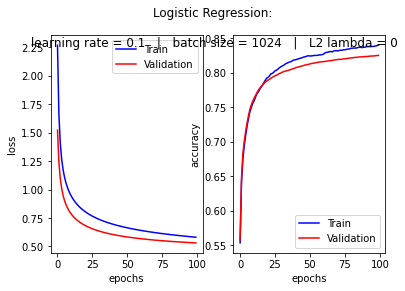

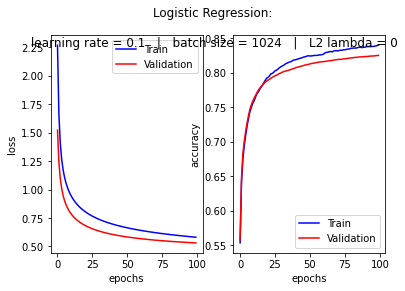

In [16]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, num_epochs, batch_size, lr, l2_lambda)

## Part 3 - Neural Network

In this section a neural network will be defined and trained. 

### ReLU activation function

The ReLU function is known to bea very effective acxtivation function since the gradients do not vanish like in the sigmoid function.

In [18]:
def relu(x):
    return np.maximum(x, 0)


def relu_derivative(x):
    y = np.zeros_like(x)
    y[x > 0] = 1
    return y

### Define the Neural Network Class

In [19]:
class NN():
    def __init__(self, NN_width, input_dim=784, act_type='relu'):

        self.input_dim = input_dim
        self.w1 = 0.1*np.random.randn(NN_width, self.input_dim)
        # self.w1 = np.random.randn(NN_width, self.input_dim)
        self.b1 = np.zeros((NN_width, 1))
        self.w2 = 0.1*np.random.randn(10, NN_width)
        # self.w2 = np.random.randn(10, NN_width)
        self.b2 = np.zeros((10, 1))
        self.epoch = 0
        self.activation = relu if act_type == 'relu' else (sigmoid if act_type == 'sigmoid' else 'Error')
        if self.activation == 'Error':
            raise IOError('activation type could be either \'relu\' or \'sigmoid\'')

        self.train_losses = []
        self.train_accuracy = []
        self.val_losses = []
        self.val_accuracy = []

    def train(self, x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda=0, dropout_keep_prob = 1):
        train_samples = x_train.shape[1]  # number of training samples

        # iterations over entire dataset
        for epoch in range(num_epochs):
            self.epoch += 1
            loss = 0
            # batch iterations within each dataset iteration
            for batch_idx, idx_start in enumerate(range(0, train_samples, batch_size)):
                idx_end = min(idx_start + batch_size, train_samples)
                x = x_train[:, idx_start:idx_end]  # take all data in the current batch
                y = y_train[:, idx_start:idx_end]  # .reshape(-1, 1)  # take relevant labels

                z1 = np.matmul(self.w1, x) + self.b1
                h = self.activation(z1)  # sigmoid / relu
                #dropout - scaled down so there is no need to change test code
                dropout_mask_1 = (np.random.rand(*h.shape) < dropout_keep_prob) / dropout_keep_prob 
                h *= dropout_mask_1
                z2 = np.matmul(self.w2, h) + self.b2
                y_pred = np.exp(z2) / (np.sum(np.exp(z2), axis=0))
                loss += cross_entropy_loss(y_pred, y) + l2_reg(self.w1, l2_lambda) + l2_reg(self.w2, l2_lambda)

                # compute gradient of the loss
                dLdz2 = y_pred - y
                dLdb2 = (1. / train_samples) * np.sum(dLdz2, axis=1, keepdims=True)
                dLdw2 = (1. / train_samples) * np.matmul(dLdz2, h.T)

                dLdh = np.matmul(self.w2.T, dLdz2)
                if self.activation == relu:
                    dLdz1 = dLdh * relu_derivative(z1)
                else:
                    dLdz1 = dLdh * sigmoid(z1) * (1 - sigmoid(z1))
                # if dopout applied in forward prop - bakprop shuld mask and scale too
                dLdh *= dropout_mask_1
                dLdw1 = (1. / train_samples) * np.matmul(dLdz1, x.T)
                dLdb1 = (1. / train_samples) * np.sum(dLdz1, axis=1, keepdims=True)

                self.w2 = self.w2 - lr * (dLdw2 + 2 * l2_lambda * self.w2)
                self.b2 = self.b2 - lr * dLdb2
                self.w1 = self.w1 - lr * (dLdw1 + 2 * l2_lambda * self.w1)
                self.b1 = self.b1 - lr * dLdb1

            train_acc, train_loss = self.test(x_train, l2_lambda, y=y_train)
            val_acc, val_loss = self.test(x_val, l2_lambda, y=y_val)
            print('Epoch:' + str(self.epoch) + '    Train Acc: ' + str(train_acc) + '    Val Acc: ' + str(val_acc))

            # save for plotting
            self.train_losses.append(loss / (len(range(0, train_samples, batch_size)) - 1))
            self.train_accuracy.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracy.append(val_acc)

        return self.train_losses, self.train_accuracy, self.val_losses, self.val_accuracy

    def test(self, x, l2_lambda, y=None):
        z1 = np.matmul(self.w1, x) + self.b1
        h = relu(z1)
        z2 = np.matmul(self.w2, h) + self.b2
        y_pred = np.exp(z2) / (np.sum(np.exp(z2), axis=0) + epsilon)
        predictions = np.argmax(y_pred, axis=0)
        if y is None:  # test case
            return predictions
        else:  # val case
            # calculate loss
            test_loss = cross_entropy_loss(y_pred, y) + l2_reg(self.w1, l2_lambda) + l2_reg(self.w2, l2_lambda)
            # calc. accuracy
            accuracy = np.mean(np.equal(np.argmax(y, axis=0), predictions))
            return accuracy, test_loss

    def save_test_predictions(self):
        test_predictions = self.test(x_test, l2_lambda, y=None).astype(int)
        file_name = 'NN_pred.csv'
        np.savetxt(file_name, test_predictions, fmt='%i')  # d = 500, Bsize = 1024, LR=1, epoch=50 acc = 0.83
        return


### Define Hyper-Parameters

In [83]:
num_epochs = 30  # number of times to iterate over the entire dataset
batch_size = 1024  # batch size
lr = 1
l2_lambda = 0.00001
NN_width = 500  # NN layer size
dropout_keep_prob=0.5

### Train and Test thew Neural Network

In [47]:
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )

Epoch:1    Train Acc: 0.5985714285714285    Val Acc: 0.6052380952380952
Epoch:2    Train Acc: 0.71625    Val Acc: 0.7116468253968254
Epoch:3    Train Acc: 0.7521428571428571    Val Acc: 0.7451984126984127
Epoch:4    Train Acc: 0.7701785714285714    Val Acc: 0.7593452380952381
Epoch:5    Train Acc: 0.7844642857142857    Val Acc: 0.7717063492063492
Epoch:6    Train Acc: 0.7898214285714286    Val Acc: 0.7787698412698413
Epoch:7    Train Acc: 0.8026785714285715    Val Acc: 0.7895833333333333
Epoch:8    Train Acc: 0.8042857142857143    Val Acc: 0.7891666666666667
Epoch:9    Train Acc: 0.81625    Val Acc: 0.799781746031746
Epoch:10    Train Acc: 0.8103571428571429    Val Acc: 0.7946031746031746
Epoch:11    Train Acc: 0.8233928571428571    Val Acc: 0.8054563492063492
Epoch:12    Train Acc: 0.8242857142857143    Val Acc: 0.8060119047619048
Epoch:13    Train Acc: 0.81375    Val Acc: 0.7977380952380952
Epoch:14    Train Acc: 0.8289285714285715    Val Acc: 0.8078571428571428
Epoch:15    Train Acc

### Plot Learning Curve - Loss and Accuracy

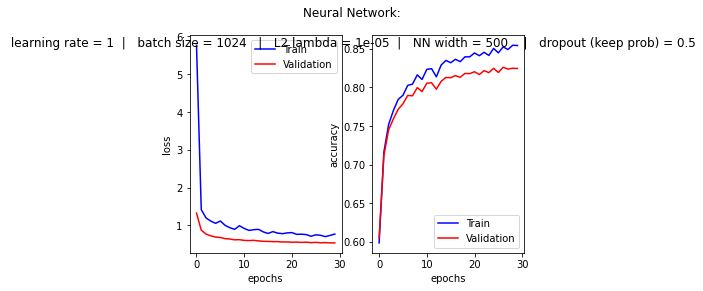

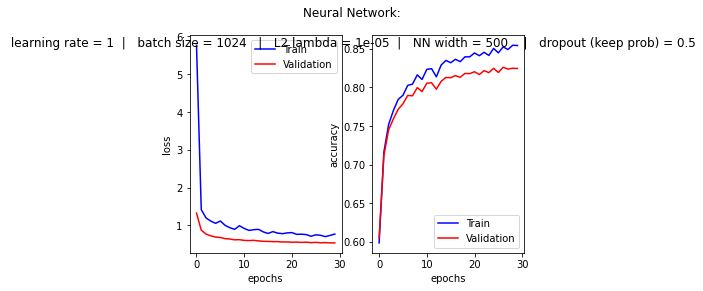

In [48]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob)

In [23]:
nn.save_test_predictions()

### Hyper-Parameter Tuning

It can be seen that the learning curve does not achive plateau so the number of epochs can be increased

In [85]:
num_epochs = 100
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )

Epoch:1    Train Acc: 0.5317857142857143    Val Acc: 0.5334523809523809
Epoch:2    Train Acc: 0.7246428571428571    Val Acc: 0.7147023809523809
Epoch:3    Train Acc: 0.7598214285714285    Val Acc: 0.748234126984127
Epoch:4    Train Acc: 0.7671428571428571    Val Acc: 0.7575
Epoch:5    Train Acc: 0.78375    Val Acc: 0.7694841269841269
Epoch:6    Train Acc: 0.7921428571428571    Val Acc: 0.781984126984127
Epoch:7    Train Acc: 0.8046428571428571    Val Acc: 0.7886309523809524
Epoch:8    Train Acc: 0.7946428571428571    Val Acc: 0.7809126984126984
Epoch:9    Train Acc: 0.8092857142857143    Val Acc: 0.7938690476190476
Epoch:10    Train Acc: 0.8155357142857143    Val Acc: 0.7997420634920634
Epoch:11    Train Acc: 0.8226785714285715    Val Acc: 0.8041269841269841
Epoch:12    Train Acc: 0.8175    Val Acc: 0.8011904761904762
Epoch:13    Train Acc: 0.8244642857142858    Val Acc: 0.8081150793650793
Epoch:14    Train Acc: 0.8175    Val Acc: 0.7998809523809524
Epoch:15    Train Acc: 0.83392857142

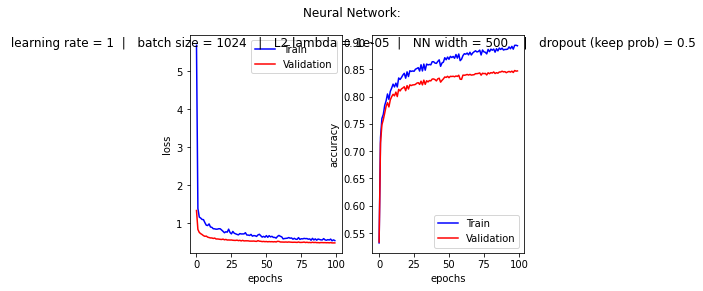

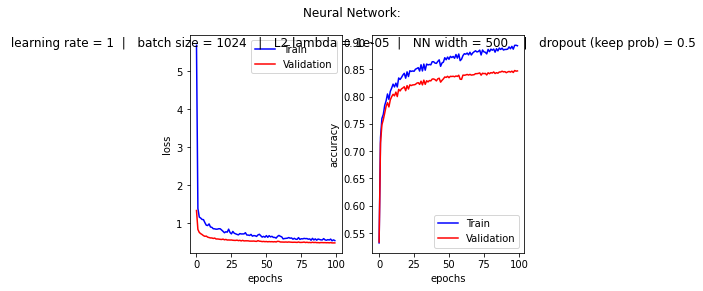

In [86]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob)

It can be seen that althought the validation accuracy increased, the training accuracy started to run away and this may be the start of overfitting.The training loss is almost equal to validation loss althought the validation metric is calculated at the end of batch. This is also a bad sign.

### Batch Size

Bath size of 1024 is a bit large. Decreasing it may cause more variations and it is related to learning rate

In [65]:
batch_size = 512

In [66]:
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )

Epoch:1    Train Acc: 0.6480357142857143    Val Acc: 0.6443650793650794
Epoch:2    Train Acc: 0.7258928571428571    Val Acc: 0.7254960317460317
Epoch:3    Train Acc: 0.7541071428571429    Val Acc: 0.748452380952381
Epoch:4    Train Acc: 0.76875    Val Acc: 0.7651190476190476
Epoch:5    Train Acc: 0.7892857142857143    Val Acc: 0.7770238095238096
Epoch:6    Train Acc: 0.8001785714285714    Val Acc: 0.7857936507936508
Epoch:7    Train Acc: 0.8057142857142857    Val Acc: 0.7898809523809524
Epoch:8    Train Acc: 0.8157142857142857    Val Acc: 0.8000793650793651
Epoch:9    Train Acc: 0.8139285714285714    Val Acc: 0.797420634920635
Epoch:10    Train Acc: 0.8235714285714286    Val Acc: 0.8081150793650793
Epoch:11    Train Acc: 0.8217857142857142    Val Acc: 0.8029563492063492
Epoch:12    Train Acc: 0.8271428571428572    Val Acc: 0.8091666666666667
Epoch:13    Train Acc: 0.8221428571428572    Val Acc: 0.8031547619047619
Epoch:14    Train Acc: 0.8323214285714285    Val Acc: 0.8127579365079365


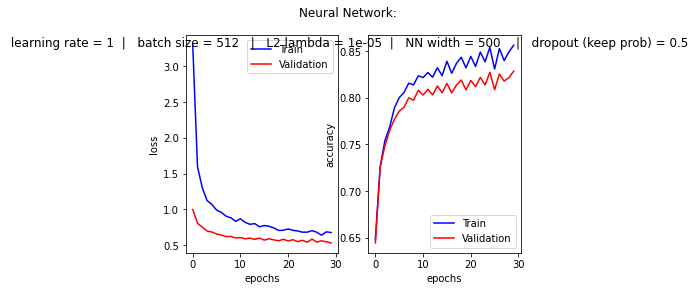

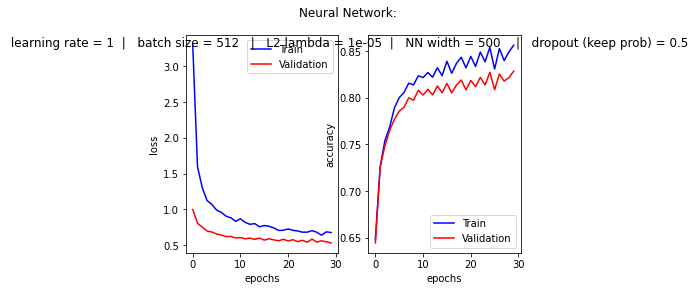

In [67]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob)

As expected, variations increased because the gradients are averaged over less samples.

### Learning Rate

In [70]:
num_epochs = 100  # number of times to iterate over the entire dataset
batch_size = 1024  # batch size
lr = 0.5
l2_lambda = 0.00001
NN_width = 500  # NN layer size
dropout_keep_prob=0.5

In [71]:
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )

Epoch:1    Train Acc: 0.6382142857142857    Val Acc: 0.6369642857142858
Epoch:2    Train Acc: 0.6998214285714286    Val Acc: 0.6920833333333334
Epoch:3    Train Acc: 0.73125    Val Acc: 0.7196031746031746
Epoch:4    Train Acc: 0.7423214285714286    Val Acc: 0.7301190476190477
Epoch:5    Train Acc: 0.7492857142857143    Val Acc: 0.7396230158730158
Epoch:6    Train Acc: 0.7742857142857142    Val Acc: 0.758095238095238
Epoch:7    Train Acc: 0.7832142857142858    Val Acc: 0.7662698412698413
Epoch:8    Train Acc: 0.7875    Val Acc: 0.7703174603174603
Epoch:9    Train Acc: 0.7939285714285714    Val Acc: 0.7764484126984127
Epoch:10    Train Acc: 0.8008928571428572    Val Acc: 0.7838888888888889
Epoch:11    Train Acc: 0.8021428571428572    Val Acc: 0.7859722222222222
Epoch:12    Train Acc: 0.8080357142857143    Val Acc: 0.7909920634920635
Epoch:13    Train Acc: 0.8103571428571429    Val Acc: 0.7926190476190477
Epoch:14    Train Acc: 0.8169642857142857    Val Acc: 0.7961507936507937
Epoch:15   

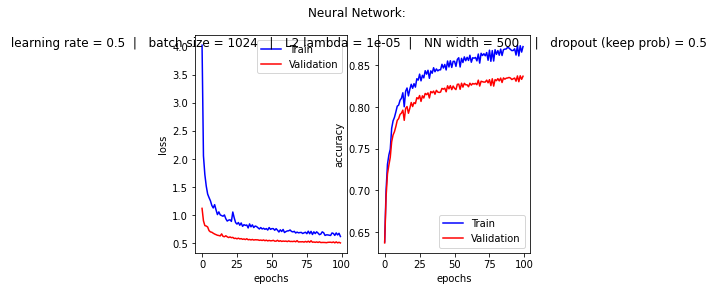

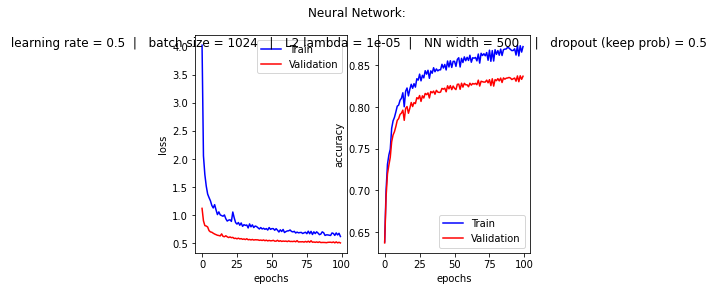

In [72]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob)

### Neural Network Width

Try to reduce hidden layer width. The more neurons the more feature the net learns. Too many features cuse overfitting.

In [80]:
num_epochs = 100  # number of times to iterate over the entire dataset
batch_size = 1024  # batch size
lr = 1
l2_lambda = 0.00001
NN_width = 200  # NN layer size
dropout_keep_prob=0.5

In [81]:
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )

Epoch:1    Train Acc: 0.6271428571428571    Val Acc: 0.6276984126984126
Epoch:2    Train Acc: 0.6951785714285714    Val Acc: 0.6832738095238096
Epoch:3    Train Acc: 0.7108928571428571    Val Acc: 0.7052777777777778
Epoch:4    Train Acc: 0.7057142857142857    Val Acc: 0.7018452380952381
Epoch:5    Train Acc: 0.7503571428571428    Val Acc: 0.7409920634920635
Epoch:6    Train Acc: 0.7571428571428571    Val Acc: 0.7476388888888889
Epoch:7    Train Acc: 0.7589285714285714    Val Acc: 0.7486111111111111
Epoch:8    Train Acc: 0.77625    Val Acc: 0.7619642857142858
Epoch:9    Train Acc: 0.7714285714285715    Val Acc: 0.7570634920634921
Epoch:10    Train Acc: 0.7785714285714286    Val Acc: 0.7674801587301587
Epoch:11    Train Acc: 0.7605357142857143    Val Acc: 0.7518452380952381
Epoch:12    Train Acc: 0.7939285714285714    Val Acc: 0.7801984126984127
Epoch:13    Train Acc: 0.7780357142857143    Val Acc: 0.7695436507936508
Epoch:14    Train Acc: 0.8033928571428571    Val Acc: 0.787559523809523

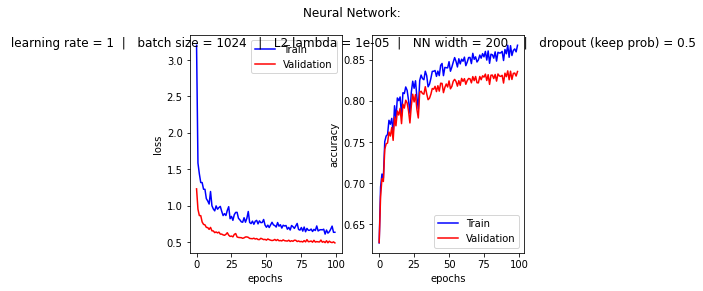

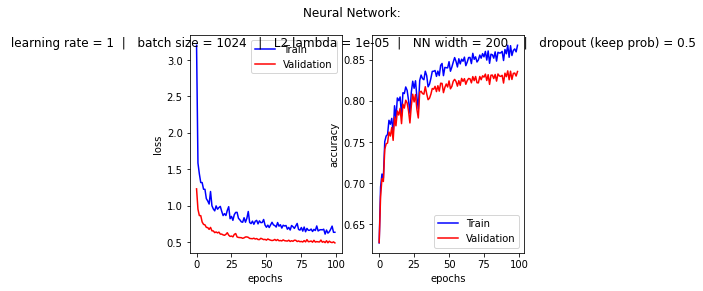

In [82]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob)